In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
data = pd.read_csv('../data/energy_data_cleaned.csv')

In [ ]:
building_ids = data['building_id']

X = data.drop(['target', 'site_id', 'building_id'], axis=1)
y = data['target']


In [5]:
X_train, X_test, y_train, y_test, bld_train, bld_test = train_test_split(
    X, y, building_ids, test_size=0.2, random_state=42)

scaler = StandardScaler()

scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print("X_train_scaled shape:", X_train_scaled.shape)
print("y_train_scaled shape:", y_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test_scaled shape:", y_test_scaled.shape)

X_train_scaled shape: (1565840, 14)
y_train_scaled shape: (1565840, 1)
X_test_scaled shape: (391461, 14)
y_test_scaled shape: (391461, 1)


In [6]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())


In [7]:
def build_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', r2_metric])
    return model

model = build_model(X_train_scaled.shape[1])
model.summary()

/opt/anaconda3/envs/meu_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,025 (191.50 KB)

 Trainable params: 48,065 (187.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_test_scaled, y_test_scaled),
    epochs=50, batch_size=64, verbose=1
)

Epoch 1/30
24467/24467 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - loss: 0.3439 - mae: 0.4140 - mse: 0.3439 - r2_metric: 0.6466 - val_loss: 0.0883 - val_mae: 0.1905 - val_mse: 0.0883 - val_r2_metric: 0.9093
Epoch 2/30
24467/24467 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 0.1532 - mae: 0.2801 - mse: 0.1532 - r2_metric: 0.8424 - val_loss: 0.0768 - val_mae: 0.1722 - val_mse: 0.0768 - val_r2_metric: 0.9211
Epoch 3/30
24467/24467 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - loss: 0.1397 - mae: 0.2666 - mse: 0.1397 - r2_metric: 0.8562 - val_loss: 0.0696 - val_mae: 0.1600 - val_mse: 0.0696 - val_r2_metric: 0.9285
Epoch 4/30
24467/24467 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 0.1338 - mae: 0.2603 - mse: 0.1338 - r2_metric: 0.8621 - val_loss: 0.0664 - val_mae: 0.1566 - val_mse: 0.0664 - val_r2_metric: 0.9318
Epoch 5/30
24467/24467 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step - loss: 0.1299 - mae: 0.2567 - mse: 0.1299 - r2_metric: 0.8662 - val_loss: 0.0643 - val_mae: 0.1525 - val_mse: 0.0643 - val_r2_metric: 0.9339
Epoch

In [9]:
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)
y_test_orig = scaler_y.inverse_transform(y_test_scaled)

mae = mean_absolute_error(y_test_orig, predictions)
mse = mean_squared_error(y_test_orig, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_orig, predictions)

print("Test metrics:")
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")


12234/12234 ━━━━━━━━━━━━━━━━━━━━ 3s 246us/step
Test metrics:
MAE: 0.25, MSE: 0.18, RMSE: 0.43, R2: 0.95


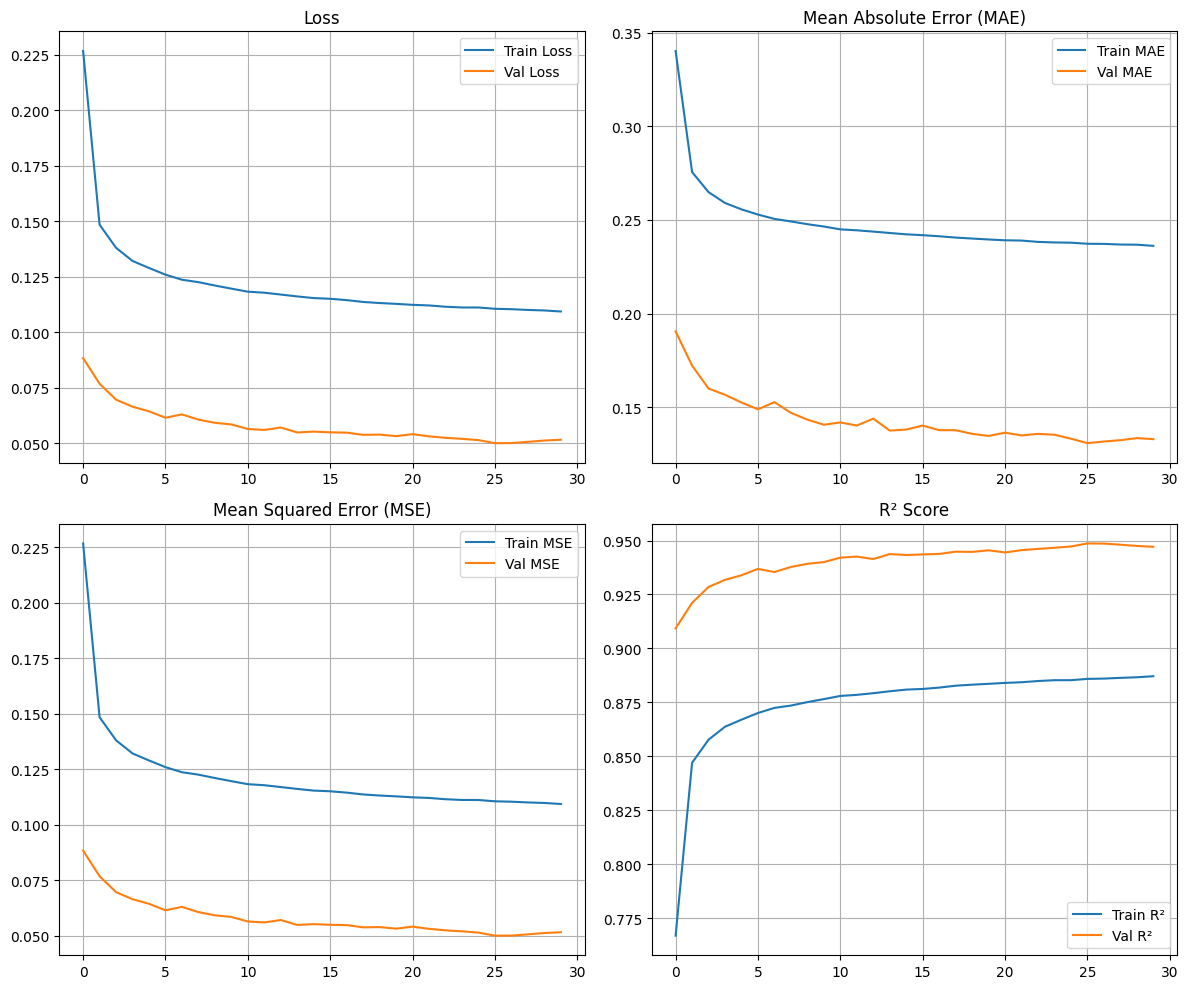

In [11]:
plt.figure(figsize=(12, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.grid(True)

# Plot MAE
plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('Mean Absolute Error (MAE)')
plt.grid(True)

# Plot MSE
plt.subplot(2, 2, 3)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.title('Mean Squared Error (MSE)')
plt.grid(True)

# Plot R²
plt.subplot(2, 2, 4)
plt.plot(history.history['r2_metric'], label='Train R²')
plt.plot(history.history['val_r2_metric'], label='Val R²')
plt.legend()
plt.title('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

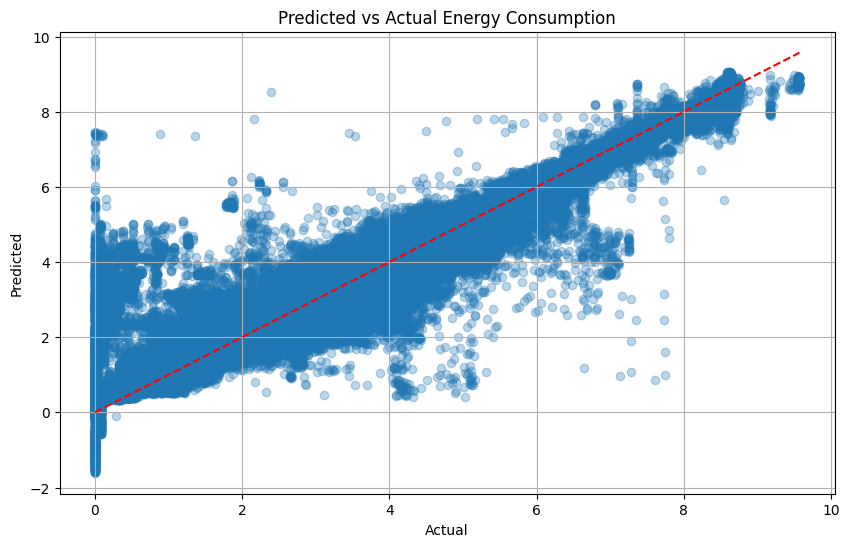

In [14]:
time_df = X_test[['month', 'day', 'hour']].copy()
time_df['year'] = 2016  # ou outro ano fixo
timestamps = pd.to_datetime(time_df[['year', 'month', 'day', 'hour']])

results_df = pd.DataFrame({
    'building_id': bld_test,
    'actual': y_test_orig.flatten(),
    'predicted': predictions.flatten(),
    'timestamp': timestamps
})

plt.figure(figsize=(10, 6))
plt.scatter(results_df['actual'], results_df['predicted'], alpha=0.3)
plt.plot([results_df['actual'].min(), results_df['actual'].max()],
         [results_df['actual'].min(), results_df['actual'].max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Energy Consumption')
plt.grid(True)
plt.show()

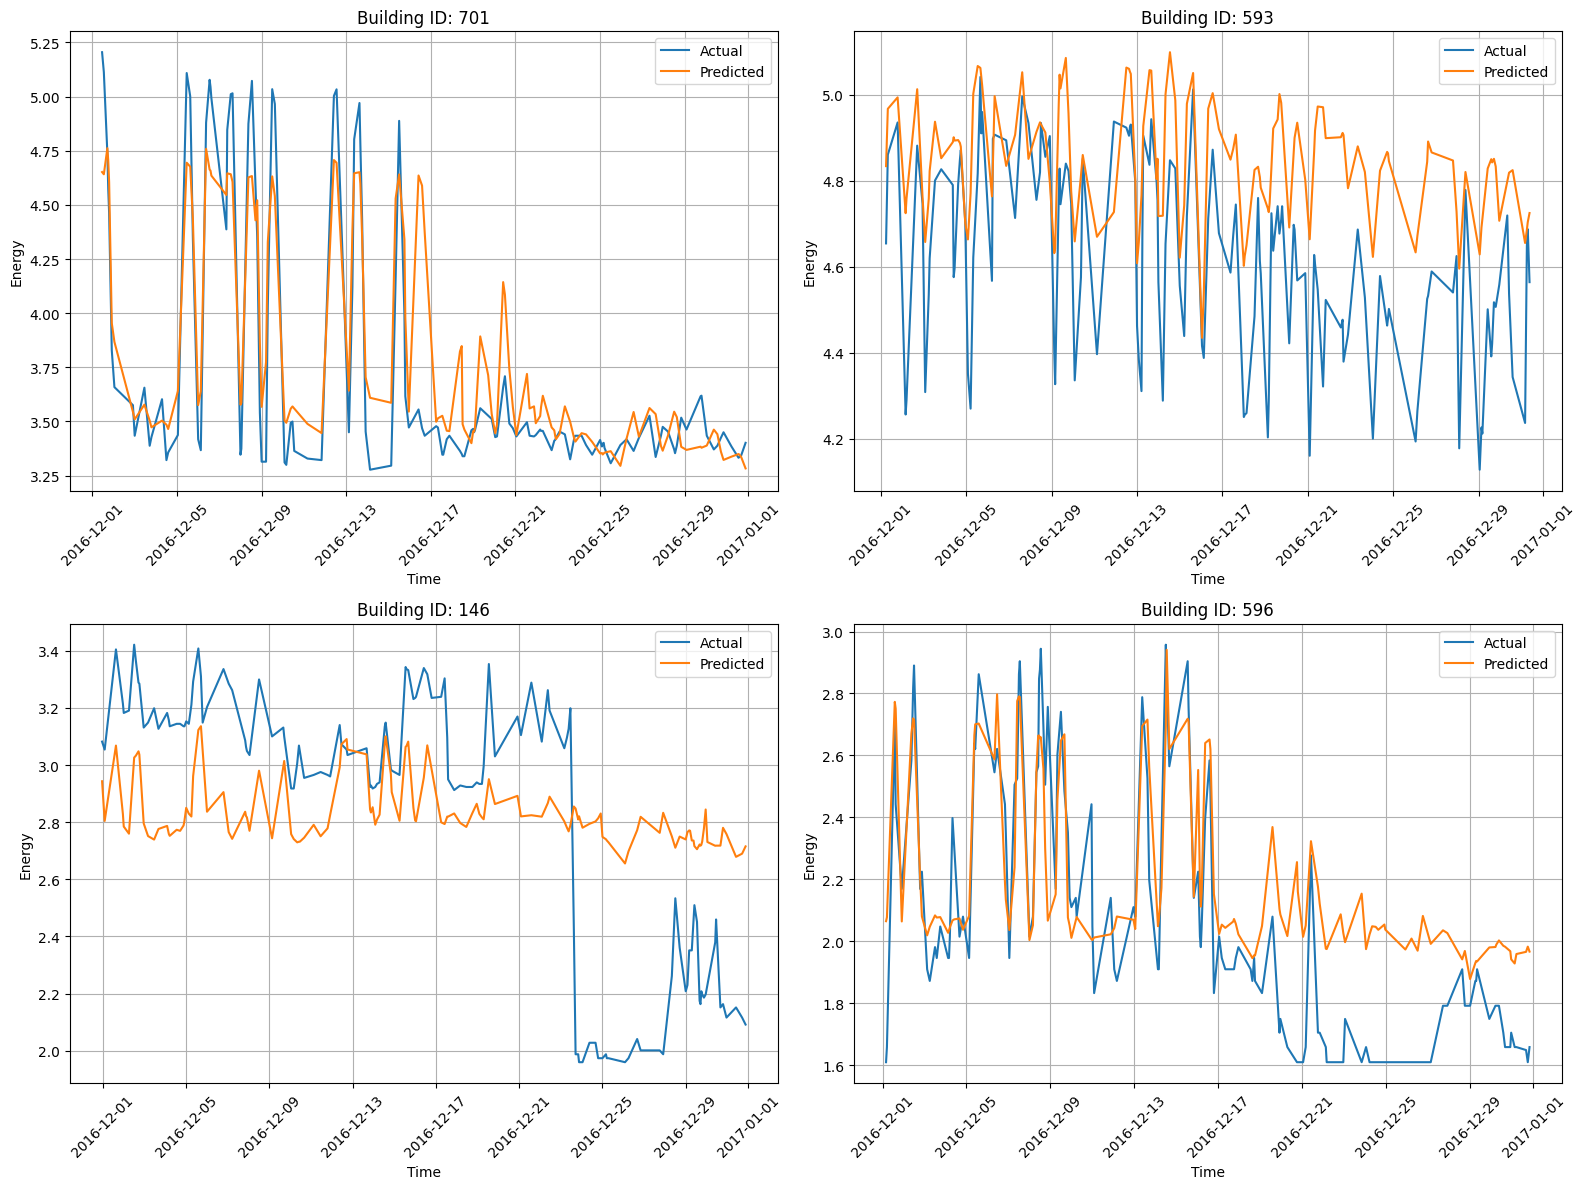

In [18]:
random_building_ids = np.random.choice(building_ids.unique(), size=4, replace=False)

# Filter results_df for the last 2 months
last_two_months = results_df['timestamp'].max() - pd.DateOffset(months=1)
filtered_results_df = results_df[results_df['timestamp'] >= last_two_months]

plt.figure(figsize=(16, 12))
for i, bid in enumerate(random_building_ids):
    subset = filtered_results_df[filtered_results_df['building_id'] == bid].sort_values(by='timestamp')
    plt.subplot(2, 2, i + 1)
    plt.plot(subset['timestamp'], subset['actual'], label='Actual')
    plt.plot(subset['timestamp'], subset['predicted'], label='Predicted')
    plt.title(f"Building ID: {bid}")
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
